* * *
<pre> NYU Paris            <i> Machine Learning - Spring 2023 </i></pre>
* * *


<h1 align="center"> Lab Unsupervised learning: clustering </h1>

<pre align="left"> April 05th 2022               <i> Author: Guillaume Staerman </i></pre>
* * *


##### Goals:
- More practice with numpy and matplotlib
- Understand the pros and cons of K-means clustering, hierarchical clustering and GMM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

seed = 42

# Part 1: Implementing K-means

In the past labs, we have mainly seen:
- dimension reduction (with PCA)
- classification (i.e supervised learning)

In practice however, the vast majority of data does not have labels. Finding structure and patterns in data without labels is called unsupervised learning. Given a specified number of clusters K, the K-means algorithm forms a partition of your data with K different groups while trying to:
- minimize the variance within groups (i.e samples forming a group must be close to each other)
- maximize the variance between groups (i.e groups must be far from each other).

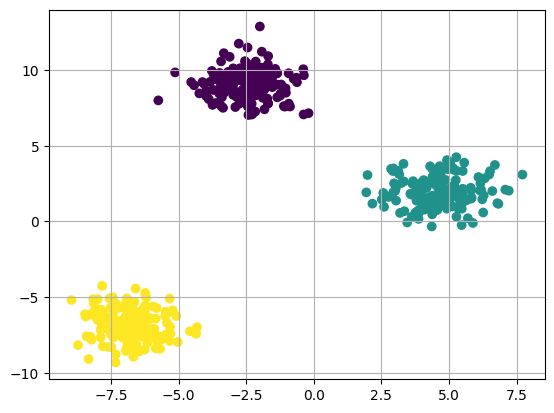

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(500, centers=3, n_features=2, cluster_std=1., random_state=seed)

plt.figure()
plt.grid()
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()


It is called K-means because it only consists of two steps. Starting from an initialization of K mean values $M_k$:
- For each sample $x$ of your data, find the mean (centroid) $C_k$ that is closest to x. Assign $x$ to group $k$.
- Update the mean $C_k$ of each group k

### Question 1
Write a function that generates K random initializations for the group centroids $C_k$. 

In [3]:
def init_centroids(K, dimension=2):
    centroids = np.random.rand(K, dimension)  # Random values in [0,1]
    return centroids

### Question 2
Write a function that takes the data X (n, d) and returns an array (n,) containing the id of the cluster it should be assigned to. For example, the function returns [0, 0, 2, 1, 2] if the first two samples are assigned to cluster 0, the 3rd and 5th samples to cluster 2 and the 4th sample to cluster 1. 

_Hint: look up `sklearn.metrics.pairwise_distances` and the numpy method of an array `array.argmin`_

In [4]:
def assign_labels(X, centroids):
    distances = np.linalg.norm(X[:, np.newaxis, :] - centroids, axis=2)  # Compute distances
    labels = np.argmin(distances, axis=1)  # Assign to closest centroid
    return labels

### Question 3
The following cell visualizes the centroids and their assigned samples. Initialize the centroids and compute a first set of labels of your data and visualize them. Can you think of a smarter way to initialize these centroids using the data? (No need to implement it for now).

In [5]:
def plot_kmeans(X, labels, centroids):
    K = len(centroids)
    colors = np.array(cm.Set1(np.linspace(0., 1, K)))
    plt.figure()
    plt.grid()
    plt.scatter(X[:, 0], X[:, 1], color=colors[labels], s=4, alpha=0.3)
    plt.scatter(centroids[:, 0], centroids[:, 1], color=colors, marker="^", s=100)
    plt.show()


### Question 4
Write a function that computes the new centroids using the assigned labels. Visualize the new centroids. Repeat these steps (label assignment + centroid update) for 2-3 steps. Does it converge?

In [6]:
def update_centroids(X, labels, centroids):
    K = centroids.shape[0]  # Number of clusters
    new_centroids = np.array([X[labels == k].mean(axis=0) if np.any(labels == k) else centroids[k] for k in range(K)])
    return new_centroids

### Question 5
The K-means algorithm repeats these operations until the centroids stop changing. Write a function summing up all these operations.

In [7]:
def Kmeans(X, K=3, maxiter=100, plot_steps=False):
    dimension = X.shape[1]
    centroids = init_centroids(K, dimension)  # Step 1: Initialize centroids

    for ii in range(maxiter):
        labels = assign_labels(X, centroids)  # Step 2: Assign labels
        new_centroids = update_centroids(X, labels, centroids)  # Step 3: Update centroids
        
        if plot_steps:
            plot_kmeans(X, labels, centroids)  

        # Stopping condition: if centroids do not change, stop
        if np.allclose(new_centroids, centroids):
            break
        
        centroids = new_centroids  # Update centroids

    return labels, centroids


### Question 6

Generate different sets of data examples (changing the `cluster_std` parameter) and visualize the K-means output. What do you notice? 

Cluster std: 0.5


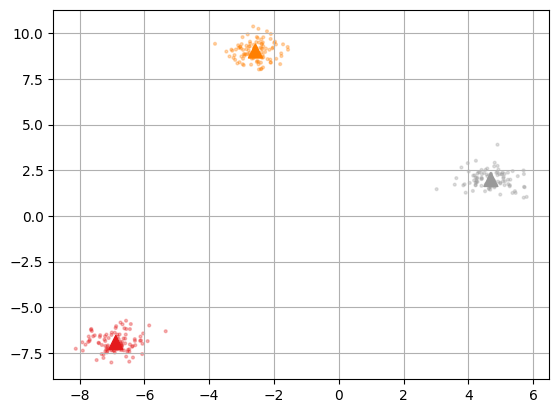

Cluster std: 1.5


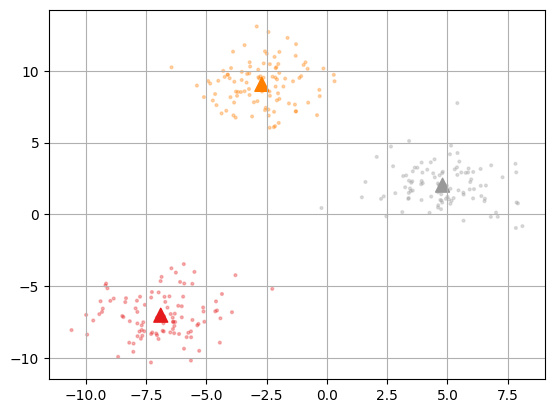

Cluster std: 3.0


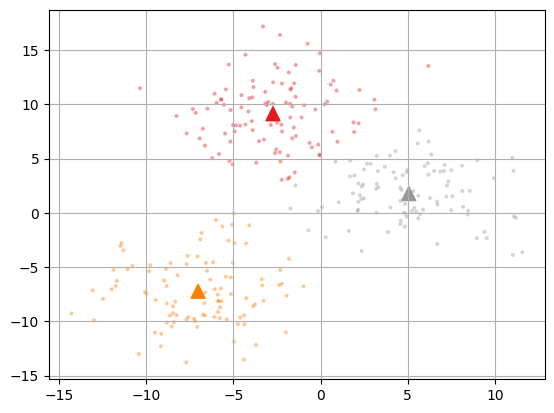

In [8]:
# Generate datasets with different cluster_std values
std_values = [0.5, 1.5, 3.0]
K = 3

for std in std_values:
    X, _ = make_blobs(n_samples=300, centers=K, cluster_std=std, random_state=42)
    labels, centroids = Kmeans(X, K)
    print(f"Cluster std: {std}")
    plot_kmeans(X, labels, centroids)

### Question 7
Try Kmeans with this new data. Choose K wisely. Is it normal that Kmeans fails?

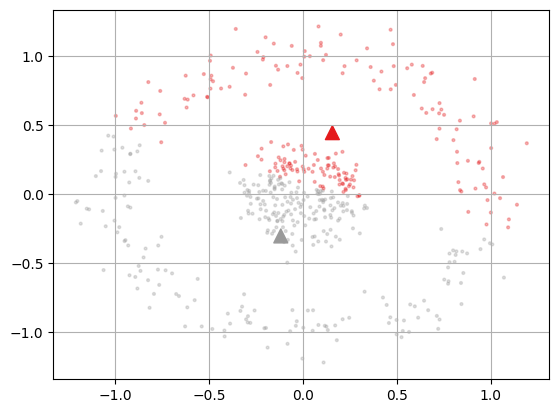

In [9]:
from sklearn.datasets import make_circles

X, y = make_circles(500, noise=0.1, factor=0.2)

# Apply K-means
K = 2  # Since make_circles has two natural clusters
labels, centroids = Kmeans(X, K)

# Plot results
plot_kmeans(X, labels, centroids)

# Part 2: Compressing images with K-means
Is it often the case that data is redundant. Take the example of the image below:

Image original shape:  (427, 640, 3)
Flower colors shape:  (273280, 3)


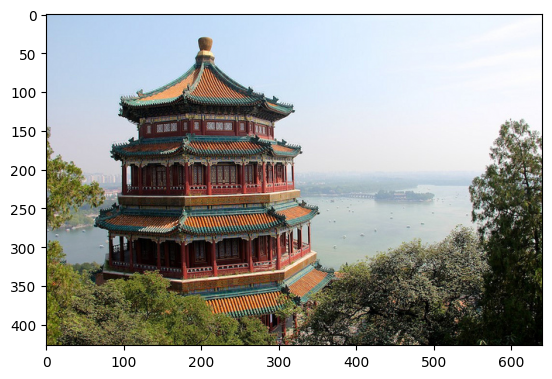

In [10]:
from sklearn.datasets import load_sample_image

flower = load_sample_image('china.jpg') / 255
flower_shape = flower.shape
flower_colors = flower.reshape(-1, 3)

print("Image original shape: ", flower_shape)
print("Flower colors shape: ", flower_colors.shape)

max_color = flower.max()

plt.figure()
plt.imshow(flower)
plt.show()

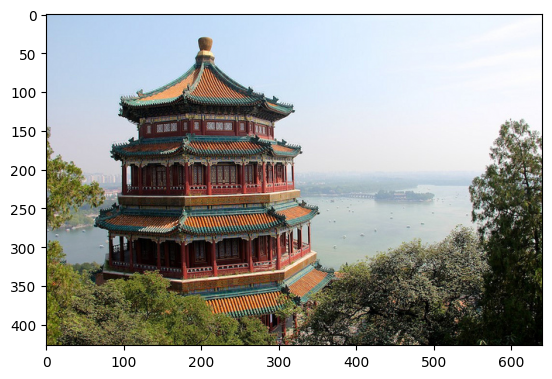

In [11]:
plt.imshow(flower)

### Question 8
We would like to replace all colors by replacing them with the centroid they're closest to. Let's for example reduce them to 16. Run the Kmeans algorithm with K=16 on the downsampled colors array X. Then create a new image with the replaced colors and visualize it.

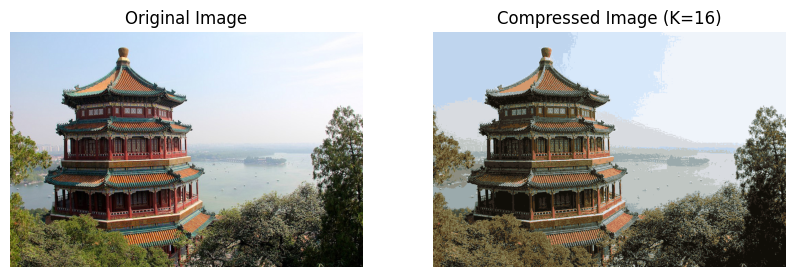

In [14]:
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
# Downsample for training
X_sample = shuffle(flower_colors, random_state=0, n_samples=1_000)

# Train K-means on the subset
K = 16
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
kmeans.fit(X_sample)

# Assign every pixel in the original image to the nearest centroid
labels = kmeans.predict(flower_colors)
compressed_colors = kmeans.cluster_centers_[labels]

# Reshape back to the original image shape
compressed_image = compressed_colors.reshape(flower_shape)

# Plot the original and compressed image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(flower)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(compressed_image)
ax[1].set_title("Compressed Image (K=16)")
ax[1].axis("off")

plt.show()


In [16]:
flower_colors.shape

(273280, 3)

In [17]:
X_sample.shape

(1000, 3)

In [8]:
flower_colors

array([[0.68235294, 0.78823529, 0.90588235],
       [0.68235294, 0.78823529, 0.90588235],
       [0.68235294, 0.78823529, 0.90588235],
       ...,
       [0.16862745, 0.19215686, 0.15294118],
       [0.05098039, 0.08235294, 0.02352941],
       [0.05882353, 0.09411765, 0.02745098]])

### Question 9
Play around with the value of n_clusters (K). What do you notice?

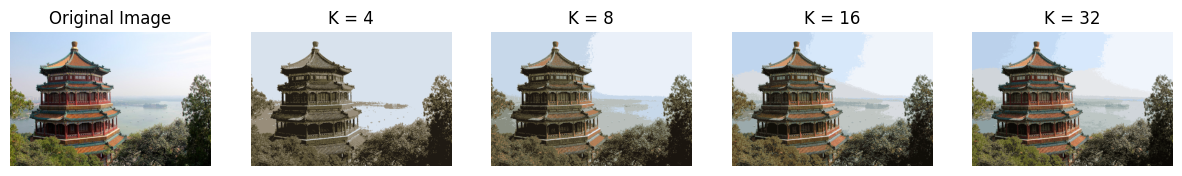

In [23]:
K_values = [4, 8, 16, 32]  # Different values of K

fig, axes = plt.subplots(1, len(K_values) + 1, figsize=(15, 5))

# Plot original image
axes[0].imshow(flower)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Apply K-means for different K values
for i, K in enumerate(K_values):
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
    kmeans.fit(X_sample)
    labels = kmeans.predict(flower_colors)
    compressed_colors = kmeans.cluster_centers_[labels]
    compressed_image = compressed_colors.reshape(flower_shape)

    axes[i + 1].imshow(compressed_image)
    axes[i + 1].set_title(f"K = {K}")
    axes[i + 1].axis("off")

plt.show()

### Question 10
Try this out but using the sklearn implementation of Kmeans. Do you obtain similar results? Can you explain the difference?

# Part 3: Implementing  Hierarchical clustering


## Question 11

Implement a function that compute the distance matrix between data. The parameter 'distance' define the chosen distance on the Euclidean space. You can use functions from scipy or sklearn. Implement three distances of your choice.

In [31]:
from scipy.spatial.distance import cdist

def distance_matrix(X, distance='euclidean'):
    return cdist(X, X, metric=distance)

## Question 12

Implement diffent similarity functions between clusters that you have seen in class (Linkage slide). Regarding the question 13, find a clever way to implement cluster variable (cluster1, cluster2).

In [28]:
def cluster_similarity(cluster1, cluster2, X, matrix_distance, linkage, distance='euclidean'):
    if linkage == 'single':
        # Minimum distance between points in the two clusters
        return np.min(matrix_distance[np.ix_(cluster1, cluster2)])

    elif linkage == 'complete':
        # Maximum distance between points in the two clusters
        return np.max(matrix_distance[np.ix_(cluster1, cluster2)])

    elif linkage == 'centroid':
        # Distance between the centroids of the two clusters
        centroid1 = np.mean(X[cluster1], axis=0)
        centroid2 = np.mean(X[cluster2], axis=0)
        return np.linalg.norm(centroid1 - centroid2)

    elif linkage == 'average':
        # Average pairwise distance between points in the two clusters
        return np.mean(matrix_distance[np.ix_(cluster1, cluster2)])

    else:
        raise ValueError("Invalid linkage method. Choose from 'single', 'complete', 'centroid', or 'average'.")


## Question 13

Implement a function that performs Agglomerative Hierarchical Clustering.

In [29]:
import numpy as np

def agglo_hier_clust(X, linkage):
    n = X.shape[0]
    clusters = {i: [i] for i in range(n)}  # Each point starts as its own cluster
    matrix_distance = distance_matrix(X)  # Compute pairwise distances

    while len(clusters) > 1:
        # Find the two closest clusters
        cluster_keys = list(clusters.keys())
        min_dist = float('inf')
        to_merge = (None, None)

        for i in range(len(cluster_keys)):
            for j in range(i + 1, len(cluster_keys)):
                c1, c2 = cluster_keys[i], cluster_keys[j]
                dist = cluster_similarity(clusters[c1], clusters[c2], X, matrix_distance, linkage)

                if dist < min_dist:
                    min_dist = dist
                    to_merge = (c1, c2)

        # Merge the two closest clusters
        c1, c2 = to_merge
        clusters[c1] += clusters[c2]  # Merge points
        del clusters[c2]  # Remove the merged cluster

    return clusters


## Question 14 (Bonus)

Implement a function that performs Divisive Hierarchical Clustering.

In [4]:
def divisive_hier_clust(X, linkage, threshold):
    
    return clusters

## Question 15

Apply this (or these) algorithm(s) on the Gaussian blobs

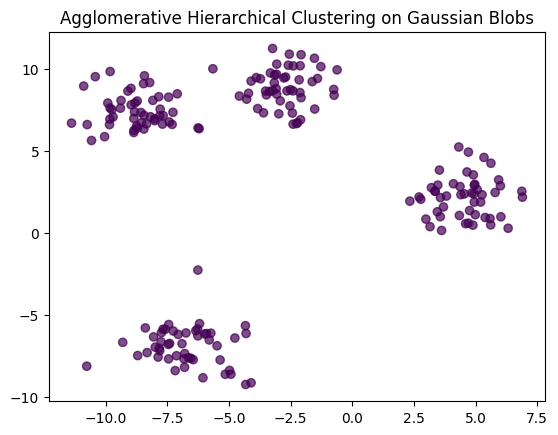

In [33]:
X, y = make_blobs(n_samples=200, centers=4, cluster_std=1.2, random_state=42)

# Run Agglomerative Hierarchical Clustering
clusters = agglo_hier_clust(X, linkage='complete')

# Assign labels based on final clusters
labels = np.zeros(len(X))
for cluster_id, points in enumerate(clusters.values()):
    labels[points] = cluster_id

# Plot the clustered data
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", alpha=0.7)
plt.title("Agglomerative Hierarchical Clustering on Gaussian Blobs")
plt.show()

## Question 16

Use now the scipy implementation of the hierarchical clustering algorithm and visualize the associated dendrogram. How many clusters should you choose inspecting the dendrogram? According to this number of cluster, compute the accuracy of the algorithm

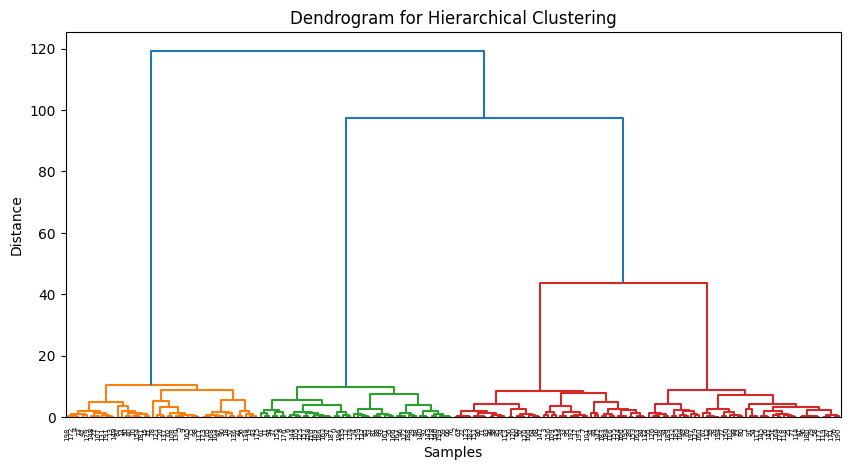

In [35]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Compute linkage matrix using Ward's method
linkage_matrix = linkage(X, method="ward")

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

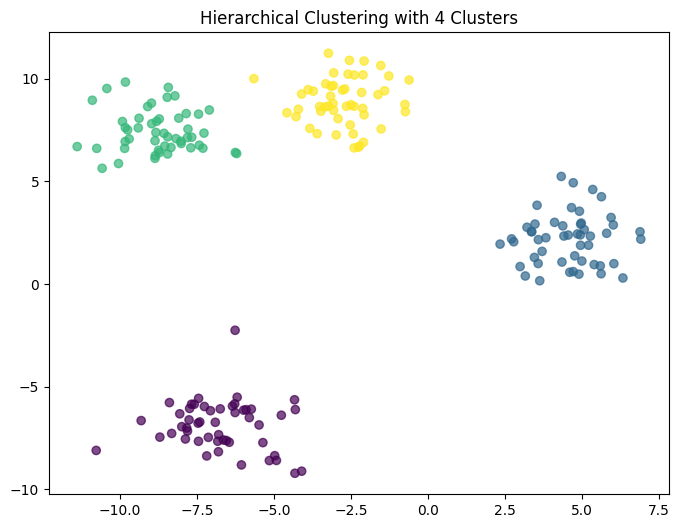

In [36]:
# Choose the number of clusters
K = 4  # You can change this based on the dendrogram cut
labels = fcluster(linkage_matrix, K, criterion="maxclust")  # Extract labels

# Plot the clustered blobs
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", alpha=0.7)
plt.title(f"Hierarchical Clustering with {K} Clusters")
plt.show()

# Part 4: Clustering Algorithms Comparison

## Question 17

- Import three images datasets as we did in previous labs: MNIST, FashionMNIST and CIFAR10. Vectorize these images to have vector input data.

In [37]:
import numpy as np
import torch
from torchvision import datasets, transforms

# Define transformations (convert images to tensors & normalize)
transform = transforms.Compose([transforms.ToTensor()])

# Load datasets
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
fashion_mnist = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
cifar10 = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)

# Convert datasets to numpy arrays and vectorize images
def vectorize_dataset(dataset):
    images = np.array([np.array(img[0]).flatten() for img in dataset])
    labels = np.array([img[1] for img in dataset])
    return images, labels

mnist_X, mnist_y = vectorize_dataset(mnist)
fashion_X, fashion_y = vectorize_dataset(fashion_mnist)
cifar_X, cifar_y = vectorize_dataset(cifar10)

print("MNIST Shape:", mnist_X.shape)  # (60000, 28*28)
print("Fashion-MNIST Shape:", fashion_X.shape)  # (60000, 28*28)
print("CIFAR-10 Shape:", cifar_X.shape)  # (50000, 32*32*3)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████| 9912422/9912422 [00:04<00:00, 2055302.60it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|███████████| 28881/28881 [00:00<00:00, 339038.36it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████| 1648877/1648877 [00:00<00:00, 2426639.63it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|████████████| 4542/4542 [00:00<00:00, 1159849.54it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|████| 26421880/26421880 [00:05<00:00, 4547087.45it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 1906912.96it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████| 4422102/4422102 [00:00<00:00, 5666405.19it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|████████████| 5148/5148 [00:00<00:00, 4987820.97it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██| 170498071/170498071 [00:41<00:00, 4117459.76it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
MNIST Shape: (60000, 784)
Fashion-MNIST Shape: (60000, 784)
CIFAR-10 Shape: (50000, 3072)


## Question 18

- Perform K-means, Hierarchical clustering and Model-based algorithms (GMM) (you all have seen these algorithms in class). You can use these algorithms from sklearn. 

NB: use images of these datasets to perform clustering, keep the labels only to assign performances of your algorithms.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score


def evaluate_clustering(y_true, y_pred):
    nmi = normalized_mutual_info_score(y_true, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    return nmi, ari
def run_clustering(X, y, dataset_name, K=10):
    print(f"\n=== {dataset_name} Clustering ===")
    
    # K-Means
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)
    nmi_kmeans, ari_kmeans = evaluate_clustering(y, kmeans_labels)
    print(f"K-Means → NMI: {nmi_kmeans:.4f}, ARI: {ari_kmeans:.4f}")

    # Hierarchical Clustering
    hier = AgglomerativeClustering(n_clusters=K)
    hier_labels = hier.fit_predict(X)
    nmi_hier, ari_hier = evaluate_clustering(y, hier_labels)
    print(f"Hierarchical → NMI: {nmi_hier:.4f}, ARI: {ari_hier:.4f}")

    # Gaussian Mixture Model (GMM)
    gmm = GaussianMixture(n_components=K, random_state=42)
    gmm_labels = gmm.fit_predict(X)
    nmi_gmm, ari_gmm = evaluate_clustering(y, gmm_labels)
    print(f"GMM → NMI: {nmi_gmm:.4f}, ARI: {ari_gmm:.4f}")

    
run_clustering(mnist_X, mnist_y, "MNIST")
run_clustering(fashion_X, fashion_y, "FashionMNIST")
run_clustering(cifar_X, cifar_y, "CIFAR-10")



=== MNIST Clustering ===
K-Means → NMI: 0.4906, ARI: 0.3607


## Question 19

Asses the performance of each algorithm.

On each dataset, describe what you observe. Overall, is there any algorithms that is better? If yes, why?

## Question 20

List pros and cons of each algorithms from what you have seen during the lab.